# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strengths
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [157]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.319556
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *The reason why we expect our loss to be close to -log(0.1) is that our formula to calculate the loss is by putting the softmax function in to the -log() function which means that we expect the result of the softmax function to be 0.1 for each class. Since the classes in the CIFAR-10 dataset are equally chosen and there are 10 different classes, we expect the probability of the correct class is 1/10 and therefore we expect the result of the softmax function to be 0.1 which makes the loss equal to -log(0.1)* 


In [156]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularizations
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.215690 analytic: 2.215690, relative error: 1.179927e-08
numerical: 1.364667 analytic: 1.364667, relative error: 1.023720e-09
numerical: 0.693530 analytic: 0.693530, relative error: 1.327956e-08
numerical: 0.418301 analytic: 0.418301, relative error: 7.330064e-09
numerical: -1.969549 analytic: -1.969549, relative error: 2.450278e-08
numerical: -0.954171 analytic: -0.954172, relative error: 4.658024e-08
numerical: 3.156872 analytic: 3.156872, relative error: 2.089859e-08
numerical: 2.198422 analytic: 2.198422, relative error: 1.668213e-08
numerical: -3.172114 analytic: -3.172114, relative error: 3.864277e-08
numerical: 2.844903 analytic: 2.844903, relative error: 6.962526e-10
numerical: 50.343120 analytic: 50.343120, relative error: 9.486435e-11
numerical: 48.759798 analytic: 48.759798, relative error: 4.503099e-10
numerical: 50.494696 analytic: 50.494696, relative error: 8.710423e-10
numerical: -47.744667 analytic: -47.744667, relative error: 1.679194e-09
numerical: -51.129

In [163]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.319568e+00 computed in 0.346597s
vectorized loss: 2.319568e+00 computed in 0.001007s
Loss difference: 0.000000
Gradient difference: 0.000000


In [159]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the validation that you did for the SVM; save      #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths_l2 = [2.5e4, 5e4]
regularization_strengths_l1 = [0, 2.5e2, 5e2]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

softmax = Softmax() #creates softmax instance

for lr, l2, l1 in [(lr, l2, l1) for lr in learning_rates for l2 in regularization_strengths_l2 for l1 in regularization_strengths_l1]:
    
    softmax.train(X_train, y_train, lr, l2, l1, num_iters=1000)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    
    training_accuracy = np.mean(y_train_pred == y_train)
    validation_accuracy = np.mean(y_val_pred == y_val)
    
    results[(lr, l2, l1)] = training_accuracy, validation_accuracy
    
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = softmax
    
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rg_l2, rg_l1 in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rg_l2,rg_l1)]
    print('lr %e rg_l2 %e rg_l1 %e train accuracy: %f val accuracy: %f' % (
                lr, rg_l2, rg_l1, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 0.000000e+00 train accuracy: 0.331163 val accuracy: 0.343000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 2.500000e+02 train accuracy: 0.218224 val accuracy: 0.222000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 5.000000e+02 train accuracy: 0.275612 val accuracy: 0.288000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 0.000000e+00 train accuracy: 0.310939 val accuracy: 0.323000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 2.500000e+02 train accuracy: 0.293265 val accuracy: 0.289000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 5.000000e+02 train accuracy: 0.305592 val accuracy: 0.301000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 0.000000e+00 train accuracy: 0.325102 val accuracy: 0.349000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 2.500000e+02 train accuracy: 0.295673 val accuracy: 0.287000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 5.000000e+02 train accuracy: 0.289857 val accuracy: 0.278000
lr 5.000000e-07 rg_l2 5.000000e+04 rg_l1 0.000000e+00 train accuracy: 0.310735 val

In [160]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.312000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$*True*


$\color{blue}{\textit Your Explanation:}$*By observing the formulas below which belong to SVM and softmax classifier losses in decreasing order: 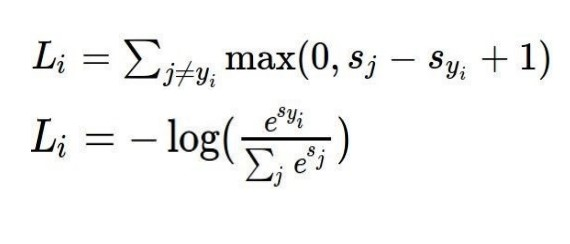
As seen above, SVM loss tries to calculate the score difference between the correct class and others. SVM loss is becomes greater when the score function of the correct class is not higher than the score of other class plus margin (delta). Therefore, we can conclude that when a new datapoint added to the training set if the score of the correct class of the datapoint is higher enough than the other claseses'score, the loss function remains unchanged. However, when we look at the softmax classifier loss, we sum the log probabilities of the correct class. Therefore, if the probability of the correct class (calculated using the softmax function) is not equal to 1 and we sum every datapoint loss over training examples, the overall score changes For instance, we have a training datapoint of which the scores are calculated as [0.6, 0.2, 0,2] and let assume that 0.6 belongs to the correct class and we selected the delta value 0.1 for softmax loss case. Since the score of the correct class is higher than the scores of other classes + delta, the overal score would not be affected by the new datapoint, however, for the softmax loss case, the must add -log(0.6) to the overall loss so it increases.*



**Inline Question 3** 

Comment on the effects of unifying L1 and L2 losses while using Elastic Net Regularization Loss? Did L2 loss achieve better when used alone or not?

$\color{blue}{\textit Your Comment:}$ *L2 loss achieved better when it is used alone with a significant difference. By keeping the L2 values same, when we compare the cases when L1 regularization parameters are 0 and 2.500000e+02, I obtained the accuracy as 0.34 and 0.22 on validation set respectively which concludes that the accuracy is apporoximately 1.5 times greater when L1 = 0.*

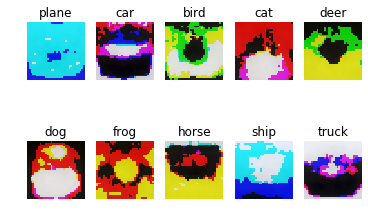

In [161]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])